In [1]:
import pandas as pd
from sodapy import Socrata
import numpy as np

In [2]:
client = Socrata("datahub.transportation.gov", 'iS5laersRc93IyBG0E5hMBsG9')

results = client.get("6axg-epim", limit=1000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [3]:
# df = df.drop(['recall_link','mfr_campaign_number'],axis=1)
## replacing nan values in the completion_rate columns with 0
df['completion_rate'] = df['completion_rate'].fillna(0)
## dropping irrelavant columns
##extracting timeseries object
df['report_received_date'] = pd.to_datetime(df['report_received_date'])
df['report_received_date'] = df['report_received_date'].dt.strftime('%Y-%m')
df

,report_received_date,nhtsa_id,recall_link,manufacturer,subject,component,mfr_campaign_number,recall_type,potentially_affected,defect_summary,consequence_summary,corrective_action,fire_risk_when_parked,do_not_drive,completion_rate
0,2023-12,23V837000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,Mazda North American Operations,Replacement Air Bag Inflator Incorrectly Insta...,AIR BAGS,6423L,Vehicle,12741,Mazda North American Operations (Mazda) is rec...,An incorrectly installed inflator may not prop...,Dealers will inspect and reinstall the front p...,No,No,0
1,2023-12,23V839000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,Great Dane Trailers,Loose Axle Spindle Nut May Cause Wheel Detachment,SUSPENSION,NR (Not Reported),Vehicle,346,Great Dane Trailers (Great Dane) is recalling ...,A loose axle spindle nut can allow the wheel t...,Great Dane will inspect and tighten the axle s...,No,No,0
2,2023-12,23V838000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,"Tesla, Inc.",Autopilot Controls Insufficient to Prevent Misuse,ELECTRICAL SYSTEM,SB-23-00-008,Vehicle,2031220,"Tesla, Inc. (Tesla) is recalling 2012-2023 Mod...",In certain circumstances when Autosteer is eng...,Tesla will release an over-the-air (OTA) softw...,No,No,0
3,2023-12,23V835000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,"Mercedes-Benz USA, LLC",Improperly Secured 12-Volt Ground Connection,ELECTRICAL SYSTEM,NR (Not Reported),Vehicle,164,"Mercedes-Benz USA, LLC (MBUSA) is recalling ce...",An overheated ground connection can increase t...,Dealers will inspect and secure the 12-Volt gr...,No,No,0
4,2023-12,23V836000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,Harley-Davidson Motor Company,Motorcycle Difficult to Control at High Speeds,ENGINE AND ENGINE COOLING,0185,Vehicle,1464,Harley-Davidson Motor Company (Harley-Davidson...,A motorcycle that is difficult to control can ...,Dealers will update the engine control module ...,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-12,22V894000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,"Old School Trailers, LLC",Awning Fabric May Detach Causing Awning to Drop,EQUIPMENT,NR (Not Reported),Vehicle,16,"Old School Trailers, LLC (Old School Trailers)...",An awning that drops or extends beyond normal ...,The remedy is still under development. Owner n...,No,No,6.25
996,2022-12,22V892000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,Pierce Manufacturing,Tie Rod Clamp Failure,STEERING,74B324,Vehicle,17,Pierce Manufacturing (Pierce) is recalling cer...,Tie rod separation can result in a sudden loss...,"Dealers will replace the tie rod clamps, free ...",No,No,90.91
997,2022-12,22V890000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,Newmar Corporation,Steering Wheel Separation,STEERING,NR (Not Reported),Vehicle,30,Newmar Corporation (Newmar) is recalling certa...,Separation of the steering wheel could result ...,Dealers will install new steering wheel cap sc...,No,No,56.67
998,2022-12,22V891000,{'url': 'https://www.nhtsa.gov/recalls?nhtsaId...,Entegra Coach,Insufficient Air Brake Supply Volume/FMVSS 121,"SERVICE BRAKES, AIR",NR (Not Reported),Vehicle,394,Entegra Coach (Entegra) is recalling certain 2...,The undersized air brake supply reservoir may ...,"Dealers will replace the air reservoir, free o...",No,No,0


In [4]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

numerical_features = df[['potentially_affected', 'completion_rate']]
euclidean_dist = euclidean_distances(numerical_features)

c:\Users\aquil\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


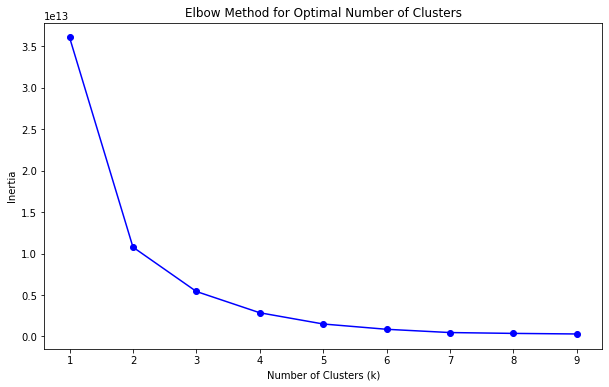

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features_for_clustering = df[['potentially_affected', 'completion_rate']]

# Try different values of k and calculate the inertia (cost) for each k
inertia_values = []
possible_k_values = range(1, 10)  # Adjusted range based on the number of data points

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_for_clustering)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


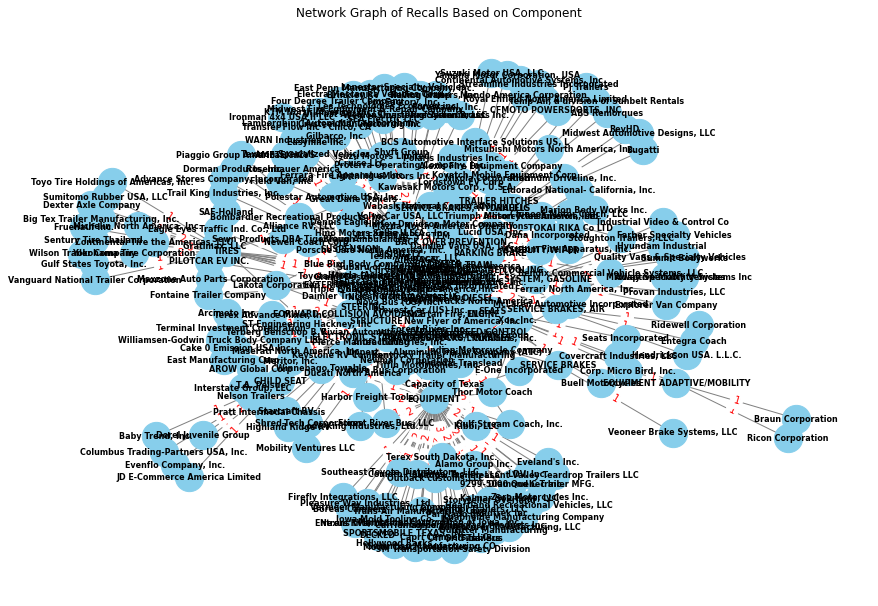

In [7]:
import networkx as nx
G = nx.Graph()

# Add nodes (components) and edges based on shared components
for index, row in df.iterrows():
    G.add_node(row['component'])
    # Check if the node already has an edge with the manufacturer
    if G.has_edge(row['component'], row['manufacturer']):
        G[row['component']][row['manufacturer']]['weight'] += 1  # Increment the weight if the edge already exists
    else:
        G.add_edge(row['component'], row['manufacturer'], weight=1)  # Add a new edge

# Draw the network graph
pos = nx.spring_layout(G)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, font_size=8, node_color='skyblue', node_size=800, font_color='black', font_weight='bold', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title('Network Graph of Recalls Based on Component')
plt.show()
nx.write_graphml(G,'recallsbasedoncomponent.graphml')

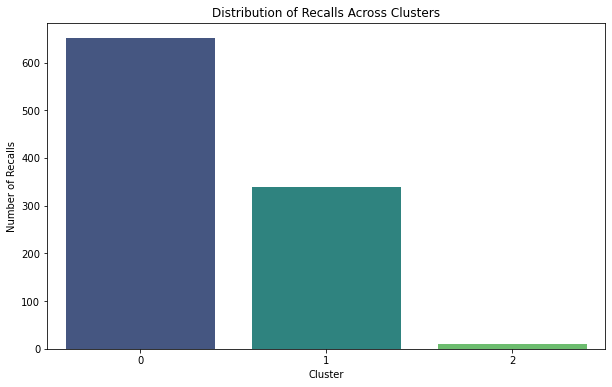

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df['potentially_affected'] = df['potentially_affected'].astype(int)
df['completion_rate'] =  df['completion_rate'].astype(float)

df['risk_score'] =1/ df['potentially_affected'] + df['completion_rate']


# Feature Scaling
scaler = StandardScaler()
df[['potentially_affected', 'completion_rate', 'risk_score']] = scaler.fit_transform(df[['potentially_affected', 'completion_rate', 'risk_score']])

# Apply K-Means clustering
num_clusters = 3  # Experiment with different values
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['potentially_affected', 'completion_rate', 'risk_score']])

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Create a countplot of the clusters
sns.countplot(x='cluster', data=df, palette='viridis')

# Customize the plot
plt.title('Distribution of Recalls Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Recalls')
plt.show()


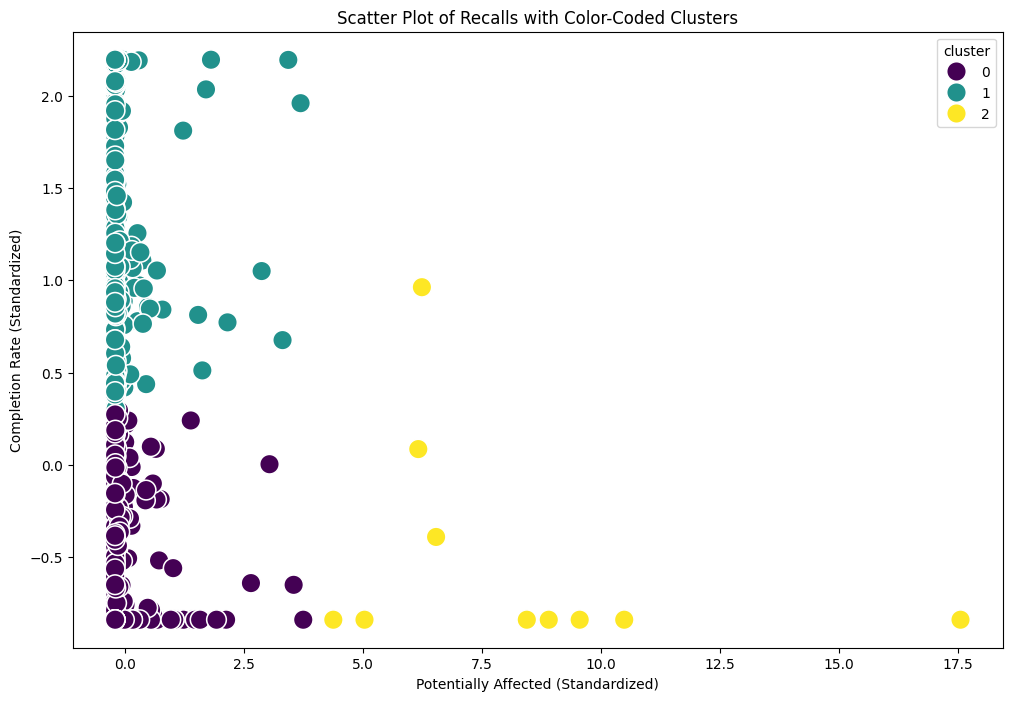

In [80]:
plt.figure(figsize=(12, 8))

scatter = sns.scatterplot(x='potentially_affected', y='completion_rate', hue='cluster', data=df, palette='viridis', s=200)

plt.title('Scatter Plot of Recalls with Color-Coded Clusters')
plt.xlabel('Potentially Affected (Standardized)')
plt.ylabel('Completion Rate (Standardized)')
plt.show()

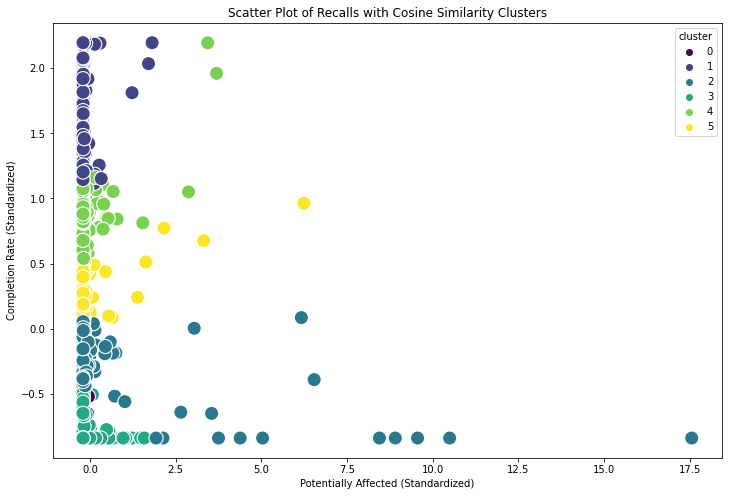

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['potentially_affected', 'completion_rate', 'risk_score']
numeric_transformer = StandardScaler()

# One-Hot Encoding for categorical features
categorical_features = ['manufacturer', 'component']
categorical_transformer = OneHotEncoder()

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X = preprocessor.fit_transform(df)

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(X)

# Apply K-Means clustering using cosine similarity matrix
num_clusters = 6  # Experiment with different values
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(cosine_sim_matrix)

# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Create a scatter plot with hue (color) based on the cluster
scatter = sns.scatterplot(x='potentially_affected', y='completion_rate', hue='cluster', data=df, palette='viridis', s=200)


# Customize the plot
plt.title('Scatter Plot of Recalls with Cosine Similarity Clusters')
plt.xlabel('Potentially Affected (Standardized)')
plt.ylabel('Completion Rate (Standardized)')
plt.show()

In [ ]:
df